In [1]:
import json

In [2]:
filename = 'log.txt'
search_string = "{\"batch_id\":"

In [3]:
def read_until_batch_id(file_path, search_string="{\"batch_id\":", chunk_size=1024):
    buffer = ""
    next_string_distances = []
    current_position = 0  # 파일 내 현재 위치를 추적
    last_position = None
    
    with open(file_path, 'r', encoding='utf-8') as file:
        while True:
            chunk = file.read(chunk_size)
            if not chunk:
                break
            
            buffer += chunk

            while True:
                pos = buffer.find(search_string)
                if pos != -1:
                    found_position = current_position + pos
                    # found_positions.append(found_position)

                    if last_position is not None:
                        next_string_distances.append(found_position - last_position)

                    last_position = found_position
                    
                    buffer = buffer[pos + len(search_string):]
                    
                    current_position += pos + len(search_string)
                else:
                    # current_position += len(buffer)
                    # buffer = buffer[max(0, len(buffer) - chunk_size):]
                    break

    return next_string_distances

next_string_distances = read_until_batch_id(filename, search_string, 1024)

In [4]:
step_time_data_list = []
with open(filename, 'r', encoding='utf-8') as file:
    read_start_point = 0
    for i, idx in enumerate(next_string_distances):
        file.seek(read_start_point)
        data = file.read(idx - 2)
        json_data = json.loads(data)
        step_time_data_list.append(json_data)
        read_start_point = read_start_point + next_string_distances[i]

In [5]:
def add_dicts(dict1, dict2):
    result = {}
    
    for key in dict1:
        if isinstance(dict1[key], dict):
            # 만약 항목이 또 다른 dict라면, 재귀적으로 처리
            result[key] = add_dicts(dict1[key], dict2[key])
        else:
            # float 값이면 더하기
            result[key] = dict1[key] + dict2[key]
    
    return result

def initialize_dict_with_zeros(d):
    initialized_dict = {}
    
    for key, value in d.items():
        if isinstance(value, dict):
            # 내부 dict일 경우, 재귀적으로 처리
            initialized_dict[key] = initialize_dict_with_zeros(value)
        else:
            # float 값일 경우, 0으로 초기화
            initialized_dict[key] = 0.0
    
    return initialized_dict

In [6]:
def initialize_empty_dict(structure):
    if isinstance(structure, dict):
        return {key: initialize_empty_dict(value) for key, value in structure.items()}
    else:
        return []

def aggregate_jsons(json_list):
    aggregated_dict = initialize_empty_dict(json_list[0])

    for json_data in json_list:
        add_values_to_dict(aggregated_dict, json_data)
    
    return aggregated_dict

def add_values_to_dict(aggregated_dict, json_data):
    for key, value in json_data.items():
        if isinstance(value, dict):
            add_values_to_dict(aggregated_dict[key], value)
        else:
            aggregated_dict[key].append(value)


In [7]:
step_time_data_list[0]

{'batch_id': '85a8a5540a3c4273b7374534ac996c0a',
 'request_num': 1,
 'adapter_num': 1,
 'arithType': 'prefill',
 'layers': [{'layer': 0,
   'atten_norm': 0.3058910369873047,
   'precache': 0.0045299530029296875,
   'get_qkv': {'total_time': 1.013040542602539,
    'detail': {'q_base': 0.14472007751464844,
     'q_lora': 0.072479248046875,
     'q_rotary_emb': 0.2589225769042969,
     'k_base': 0.10013580322265625,
     'k_lora': 0.06556510925292969,
     'k_rotary_emb': 0.1971721649169922,
     'v_base': 0.07295608520507812,
     'v_lora': 0.06079673767089844}},
   'postcache': 0.3733634948730469,
   'atten_calc': 0.3650188446044922,
   'get_o': {'total_time': 0.16999244689941406,
    'detail': {'o_base': 0.0934600830078125, 'o_lora': 0.06127357482910156}},
   'total_attention_time': 2.318859100341797,
   'total_ffn_time': 20.389318466186523},
  {'layer': 1,
   'atten_norm': 0.1804828643798828,
   'precache': 0.0035762786865234375,
   'get_qkv': {'total_time': 0.6918907165527344,
    'd

In [119]:
for step in step_time_data_list:
    summary = initialize_dict_with_zeros(step_time_data_list[0]["layers"][0])
    step["summary"] = summary
    
    for layer in step["layers"]:
        step["summary"] = add_dicts(step["summary"], layer)

In [120]:
prefill_steps = [step for step in step_time_data_list if step["arithType"]=="prefill"]
decode_steps = [step for step in step_time_data_list if step["arithType"]=="decode"]

In [121]:
print(len(prefill_steps))
print(len(decode_steps))

637
7387


## To see the steps, use step_time_data_list

In [122]:
import matplotlib.pyplot as plt

def plot_request_and_adapter_numbers(step_list):
    step = range(len(step_list))
    request_numbers = [step["request_num"] for step in step_list]
    adapter_numbers = [step["adapter_num"] for step in step_list]
    
    plt.plot(step, request_numbers, label='Request numbers(Batch size)')
    plt.plot(step, adapter_numbers, label='Adapter numbers')
    
    plt.title("Adapter Numbers")
    plt.xlabel("Step")
    plt.ylabel("Number")
    
    plt.legend()
    
    plt.show()

In [129]:
import matplotlib.pyplot as plt

def plot_batch_and_summaries(step_list):
    step = range(len(step_list))
    request_numbers = [step["request_num"] for step in step_list]
    adapter_numbers = [step["adapter_num"] for step in step_list]
    
    summarys = [step["summary"] for step in step_list]
    
    summary_dict = aggregate_jsons(summarys)
    
    fig, ax1 = plt.subplots()
    ax1.plot(step, request_numbers, color='purple', label='Request numbers(Batch size)')
    #ax1.plot(step, adapter_numbers, color='brown', label='Adapter numbers')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Numbers')
    ax1.tick_params(axis='y')
    
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()
    #ax2.plot(step, summary_dict["total_ffn_time"], label='total_ffn_time')
    #ax2.plot(step, summary_dict["total_attention_time"], label='total_attention_time')
    #ax2.plot(step, summary_dict["atten_norm"], label='atten_norm')
    #ax2.plot(step, summary_dict["precache"], label='precache')
    ax2.plot(step, summary_dict["get_qkv"]["total_time"], label='get_qkv')
    #ax2.plot(step, summary_dict["postcache"], label='postcache')
    #ax2.plot(step, summary_dict["atten_calc"], label='atten_calc')
    #ax2.plot(step, summary_dict["get_o"]["total_time"], label='get_o')
    
    ax2.set_ylabel('Func times')
    ax2.tick_params(axis='y')
    #ax2.set_ylim(0, 400)
    ax2.legend(loc='upper right')
    
    ax1.legend(loc='center left', bbox_to_anchor=(1.15, 0.8))
    ax2.legend(loc='center left', bbox_to_anchor=(1.15, 0.5))
    
    plt.title('Relationship of Batch size and time')
    
    plt.show()
 

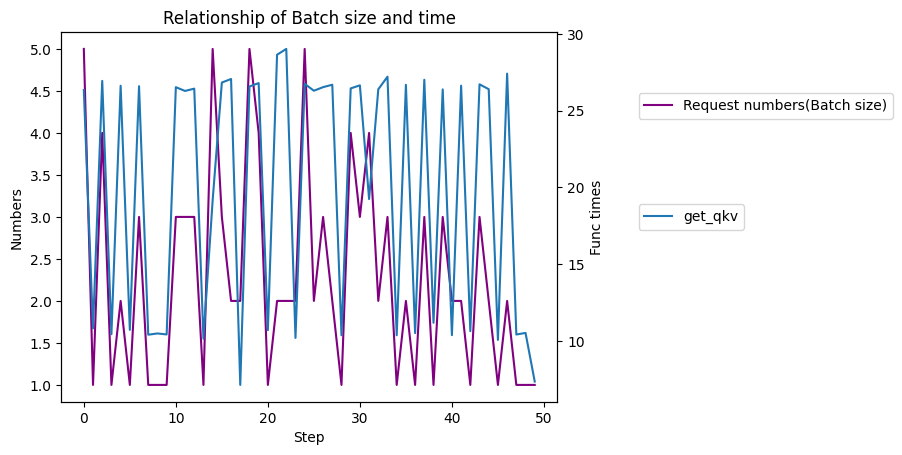

In [130]:
plot_batch_and_summaries(prefill_steps[450:500])

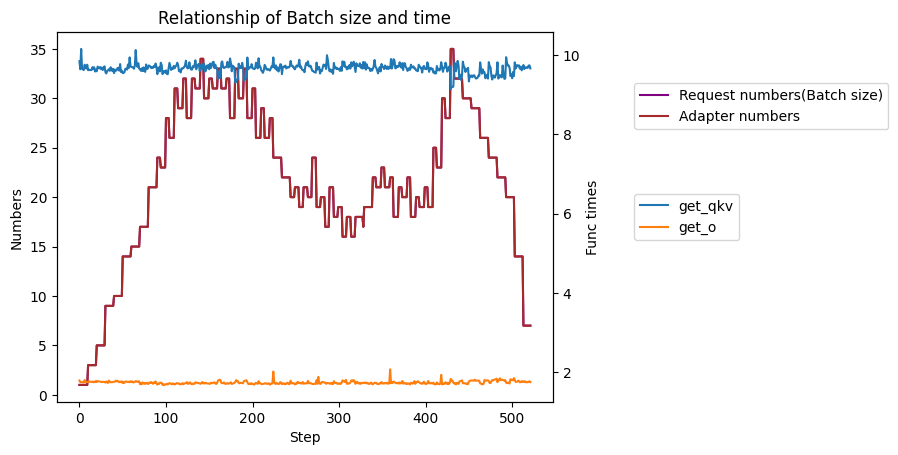

In [112]:
plot_batch_and_summaries(decode_steps)

In [96]:
decode_steps[25]["adapter_num"]

4

## To group decoding steps into 1, run :

In [79]:
batch_list = []
previous_batch_arithType = None
for step in step_time_data_list:
    if step["arithType"] != previous_batch_arithType:
        batch = {
            "arithmeticType": step["arithmeticType"],
            "request_num": step["request_num"],
            "adapter_num": step["adapter_num"],
            "steps": [],
            "summaries" : []
        }
        batch_list.append(batch)
        previous_batch_arithType = step["arithmeticType"]
    
    batch_list[-1]["steps"].append(step["layers"]) # batch_steps 2차원 리스트
    batch_list[-1]["summaries"].append(step["summary"]) # batch_steps 2차원 리스트

In [81]:
#print(json.dumps(batch_list[1], indent=4))
print(json.dumps(batch_list[1]["summaries"][0], indent=4))

{
    "layer": 496.0,
    "atten_norm": 3.0841827392578125,
    "precache": 0.9558200836181641,
    "get_qkv": {
        "total_time": 13.160943984985352,
        "detail": {
            "q_base": 1.3835430145263672,
            "q_lora": 0.8037090301513672,
            "q_rotary_emb": 3.3245086669921875,
            "k_base": 1.4197826385498047,
            "k_lora": 0.8528232574462891,
            "k_rotary_emb": 2.789735794067383,
            "v_base": 1.2888908386230469,
            "v_lora": 0.8041858673095703
        }
    },
    "postcache": 0.06079673767089844,
    "atten_calc": 8.097410202026367,
    "get_o": {
        "total_time": 2.413511276245117,
        "detail": {
            "o_base": 1.461029052734375,
            "o_lora": 0.7615089416503906
        }
    },
    "total_attention_time": 28.911828994750977,
    "total_ffn_time": 8.282661437988281
}


In [83]:
for batch in batch_list:
    summary_total = initialize_dict_with_zeros(batch["summaries"][0])
    for summary in batch["summaries"]:
        summary_total = add_dicts(summary_total, summary)
    batch["summary_total"] = summary_total

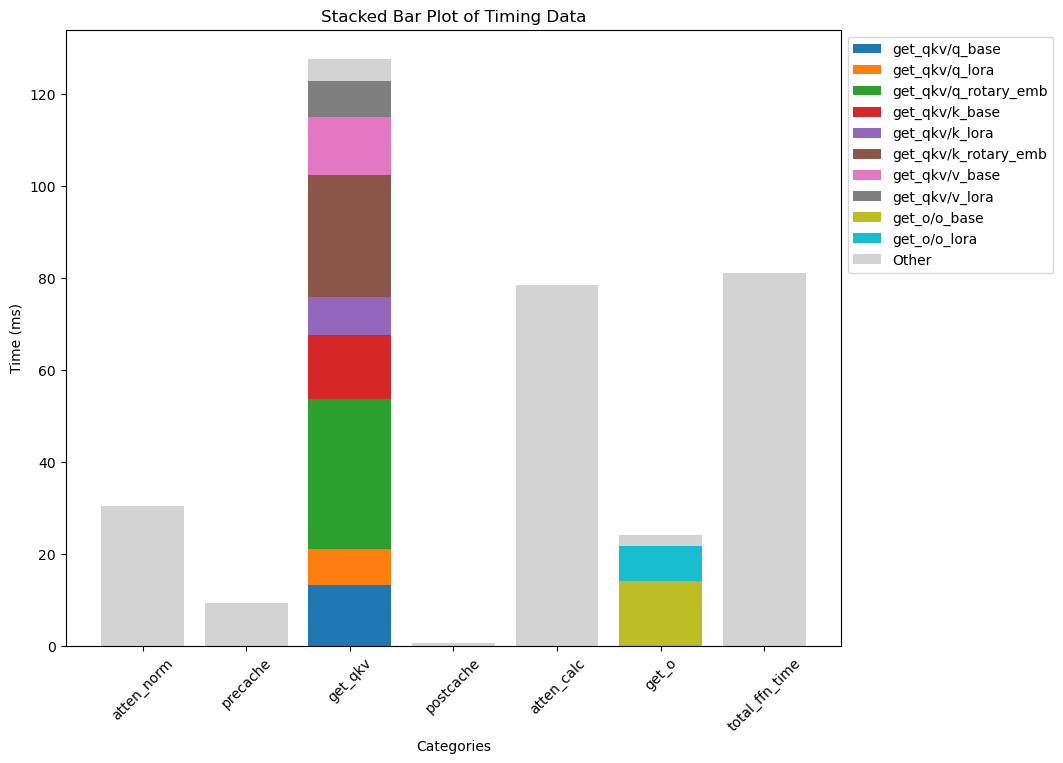

In [209]:
import matplotlib.pyplot as plt

# 데이터를 분리하여 정리
categories = ['atten_norm', 'precache', 'get_qkv', 'postcache', 'atten_calc', 'get_o', 'total_ffn_time']
get_qkv_keys = ['q_base', 'q_lora', 'q_rotary_emb', 'k_base', 'k_lora', 'k_rotary_emb', 'v_base', 'v_lora']
get_o_keys = ['o_base', 'o_lora']

# 최상위 항목
values = {
    'atten_norm': 30.407428741455078,
    'precache': 9.26065444946289,
    'get_qkv': 127.5789737701416,
    'postcache': 0.5679130554199219,
    'atten_calc': 78.44161987304688,
    'get_o': 23.496389389038086,
    'total_ffn_time': 81.11763000488281
}

# 중첩된 dict의 값들
get_qkv_values = [13.132810592651367, 7.880687713623047, 32.62901306152344, 13.867378234863281, 8.330345153808594, 26.57461166381836, 12.489795684814453, 7.851362228393555]
get_o_values = [14.15705680847168, 7.492303848266602]

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# 각 항목의 값을 누적
bottom_values = [0] * len(categories)
for i, key in enumerate(get_qkv_keys):
    ax.bar(categories, [get_qkv_values[i] if c == 'get_qkv' else 0 for c in categories], bottom=bottom_values, label=f'get_qkv/{key}')
    values["get_qkv"] = values["get_qkv"] - get_qkv_values[i]
    bottom_values = [bottom_values[j] + (get_qkv_values[i] if c == 'get_qkv' else 0) for j, c in enumerate(categories)]

for i, key in enumerate(get_o_keys):
    ax.bar(categories, [get_o_values[i] if c == 'get_o' else 0 for c in categories], bottom=bottom_values, label=f'get_o/{key}')
    values["get_o"] = values["get_o"] - get_qkv_values[i]
    bottom_values = [bottom_values[j] + (get_o_values[i] if c == 'get_o' else 0) for j, c in enumerate(categories)]

# 최상위 항목들 추가
ax.bar(categories, list(values.values()), bottom=bottom_values, color='lightgray', label='Other')

# 그래프 설정
ax.set_xlabel('Categories')
ax.set_ylabel('Time (ms)')
ax.set_title('Stacked Bar Plot of Timing Data')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))

plt.xticks(rotation=45)
plt.show()


In [197]:
bottom_values

[0, 0, 122.7560043334961, 0, 0, 21.64936065673828, 0]